In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=2,                     # Number of cores per task (adjust if needed)
    processes=5,                 # One process per task
    memory="100GB",               # --mem
    walltime="01:00:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35483 instead
  warnings.warn(


In [2]:
from dask.distributed import Client

cluster.scale(jobs=10)
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.42.239.61:33705' processes=50 threads=100, memory=0.91 TiB>

In [5]:
infol = '/home1/nalex2023/Datasets/IMERG/'
import glob 
import xarray as xr 

all_files = glob.glob(infol + '*.nc')



In [19]:

def prepro(ds):
    ds = ds.sel(lon=slice(140,150),lat=slice(-3,-1))
    return ds


#dset = xr.open_mfdataset(all_files, combine='by_coords', parallel=True, preprocess=prepro)

dset_test = xr.open_dataset(all_files[0]).sel(lat=slice(-3,-1),lon=slice(140,150))

dset_test

<xarray.Dataset> Size: 41MB
Dimensions:        (time: 5136, lon: 100, lat: 20)
Coordinates:
  * lat            (lat) float32 80B -2.95 -2.85 -2.75 ... -1.25 -1.15 -1.05
  * lon            (lon) float32 400B 140.1 140.1 140.2 ... 149.8 149.8 149.9
  * time           (time) object 41kB 2000-06-01 00:00:00 ... 2000-12-31 23:0...
Data variables:
    precipitation  (time, lon, lat) float32 41MB ...

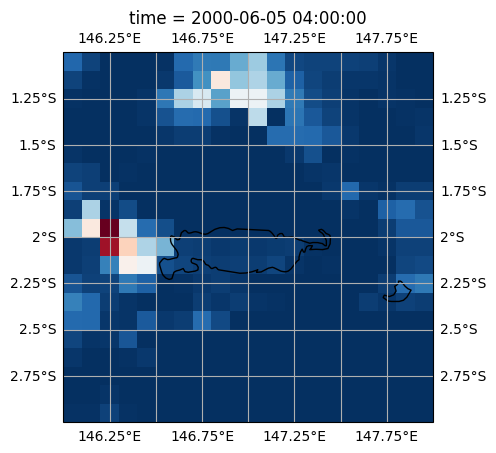

In [34]:
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})

dset_test.isel(time=100).precipitation.T.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='RdBu_r',
                                              add_colorbar=False)

ax.coastlines()
ax.set_extent([146,148,-3,-1])

# add tick labels and tick marks
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

# remove the gridlines 
ax.grid(False)



In [20]:
dset

<xarray.Dataset> Size: 954MB
Dimensions:        (time: 119088, lon: 100, lat: 20)
Coordinates:
  * lat            (lat) float32 80B -2.95 -2.85 -2.75 ... -1.25 -1.15 -1.05
  * lon            (lon) float32 400B 140.1 140.1 140.2 ... 149.8 149.8 149.9
  * time           (time) object 953kB 2000-06-01 00:00:00 ... 2013-12-31 23:...
Data variables:
    precipitation  (time, lon, lat) float32 953MB dask.array<chunksize=(5136, 100, 20), meta=np.ndarray>

In [21]:
dset_hourly = dset.groupby('time.hour').mean()

In [22]:
outfol = '/home1/nalex2023/Datasets/IMERG/'

dset_hourly.to_netcdf(outfol+'hourly_ave.nc')

In [30]:
hourly_dset = xr.open_dataset(outfol+'hourly_ave.nc')




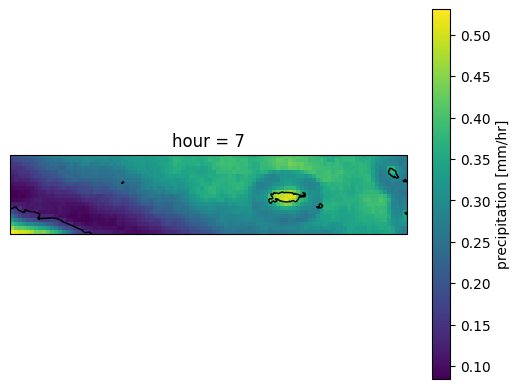

In [55]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})

hourly_dset.isel(hour=7)['precipitation'].T.plot(ax=ax,cmap='viridis')
ax.coastlines()




In [4]:
import xarray as xr
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [5]:
import glob
met_fol = '/home1/nalex2023/Datasets/met_manus/'
all_files = glob.glob(met_fol + '*.cdf')

all_files

['/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20020401.000000.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20040725.000001.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20070319.000000.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20060414.000000.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20041010.000000.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20000730.000001.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20110718.000000.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.19990514.000059.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.19980219.000059.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20101009.000000.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20030425.000001.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20080418.000000.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.20050701.000000.cdf',
 '/home1/nalex2023/Datasets/met_manus/twpmetC1.b1.19971110.00000

In [6]:
import os 

def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')


    return dft


dft = create_dft(met_fol,arm_data=True).sort_values('datetime')

dft_sub = dft.loc[(dft['datetime'] > '2000') & (dft['datetime'] < '2013')]

dft_sub

,filepath,filename,datetime
3481,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20000102.000001.cdf,2000-01-02 00:00:01
867,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20000103.000000.cdf,2000-01-03 00:00:00
1904,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20000104.000001.cdf,2000-01-04 00:00:01
6043,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20000105.000000.cdf,2000-01-05 00:00:00
2190,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20000106.000000.cdf,2000-01-06 00:00:00
...,...,...,...
182,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20121227.000000.cdf,2012-12-27 00:00:00
3352,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20121228.000000.cdf,2012-12-28 00:00:00
2332,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20121229.000000.cdf,2012-12-29 00:00:00
5538,/home1/nalex2023/Datasets/met_manus/twpmetC1.b...,twpmetC1.b1.20121230.000000.cdf,2012-12-30 00:00:00


In [ ]:
dset_met = xr.open_mfdataset(dft_sub['filepath'], combine='nested', parallel=True)


: 